In [29]:
import re #pacchetto per espressioni regolari
import os #pacchetto per muoversi nelle cartelle
import sys
sys.path.append('..')  # Add parent directory to the Python path
from utils.helpers import *


In [30]:
conllu_dir = 'data/profiling_output/11459/'

In [31]:
all_documents = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    document = Document(file_path)
    load_document_sentences(document)
    all_documents.append(document)

In [32]:
sample_document = all_documents[0]
for sentence in sample_document.sentences[:2]:
    tokens = [token.word for token in sentence.tokens]
    print(' - '.join(tokens))
    print('\n_________________\n')

1 - -11 - - - 17

_________________

Torniamo - da - i - Vanzo - .

_________________



In [33]:
def extract_word_ngrams_from_sentence(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole
    if el == 'word':
        all_words = sentence.get_words()
    elif el == 'lemma':                             
        all_words = sentence.get_lemmas()
    elif el == 'pos':
        all_words = sentence.get_pos()
    else:
        raise Exception(f'Invalid element {el}')
    

    # scorriamo la lista delle parole ed estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1): # -n+1 serve per non uscire dal vettore
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        # print(f'{i}: {ngram_words} -> {ngram}')
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1

    return word_ngrams

In [34]:
def extract_documents_ngrams(all_documents, n):
    for document in all_documents:
        document_ngrams = dict()
        for sentence in document.sentences:
            extract_word_ngrams_from_sentence(document_ngrams, sentence, 'word', n)
            
        document.features = document_ngrams

In [35]:
def extract_documents_ngrams_normalized(all_documents, n):
    for document in all_documents:
        word_ngrams = dict()
        for sentence in document.sentences:
            extract_word_ngrams_from_sentence(word_ngrams, sentence, 'word', n)

        num_words = document.get_num_tokens()
        normalize_ngrams(word_ngrams, num_words)

        document_ngrams = word_ngrams 

        document.features = document_ngrams

# Bigrammi con Word, POS, Lemma

In [36]:
extract_documents_ngrams(all_documents, n=2) # n=unigramma, bigramma, trigramma, quadrigramma

In [37]:
extract_documents_ngrams_normalized(all_documents, n=2)

In [39]:
def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.gender)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.gender)
    
    return train_features_dict, train_labels, test_features_dict, test_labels

In [40]:
train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)

In [41]:
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels)


(200, 200, 74, 74)

In [42]:
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')

Numero features: 58424


In [14]:
#train_features_dict = filter_features(train_features_dict, 5)
#print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')

In [43]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)

In [44]:
vectorizer.get_feature_names_out(X_train).tolist()

['WORD_2_!!!_Felice',
 'WORD_2_!!_!',
 'WORD_2_!!_)',
 'WORD_2_!!_.',
 'WORD_2_!_!',
 'WORD_2_!_!!',
 'WORD_2_!_"',
 'WORD_2_!_)',
 'WORD_2_!_,',
 'WORD_2_!_-',
 'WORD_2_!_.',
 'WORD_2_!_:',
 'WORD_2_!_?',
 'WORD_2_!_Dio',
 'WORD_2_!_Provessore',
 'WORD_2_!_Quel',
 'WORD_2_!_atroce',
 'WORD_2_!_dato',
 'WORD_2_!_perchè',
 'WORD_2_!_voce',
 'WORD_2_!_»',
 'WORD_2_!_”',
 'WORD_2_!…_"',
 'WORD_2_!…_dovete',
 'WORD_2_!…_”',
 'WORD_2_"_!',
 'WORD_2_"_"',
 'WORD_2_"_(',
 'WORD_2_"_)',
 'WORD_2_"_,',
 'WORD_2_"_-',
 'WORD_2_"_.',
 'WORD_2_"_;',
 'WORD_2_"_A',
 'WORD_2_"_Abbiamo',
 'WORD_2_"_Adesso',
 'WORD_2_"_Allegro',
 'WORD_2_"_Allughite',
 'WORD_2_"_Auguri',
 'WORD_2_"_Bastianu',
 'WORD_2_"_Bè',
 'WORD_2_"_Che',
 'WORD_2_"_Ci',
 'WORD_2_"_Ciao',
 'WORD_2_"_Danzo',
 'WORD_2_"_Diario',
 'WORD_2_"_Dimentica',
 'WORD_2_"_E',
 'WORD_2_"_Eh',
 'WORD_2_"_Espresso',
 'WORD_2_"_Farina',
 'WORD_2_"_Fate',
 'WORD_2_"_Ginamona',
 'WORD_2_"_Già',
 'WORD_2_"_Giò',
 'WORD_2_"_Gobbetta',
 'WORD_2_"_Grazi

In [45]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the parameter grid to search through
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

Best parameters found: {'C': 0.001, 'dual': True}
Best score found: 0.57


In [49]:
X_test = vectorizer.transform(test_features_dict)
X_test = scaler.transform(X_test)

In [50]:
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

In [52]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True

              precision    recall  f1-score   support

           F       0.72      0.62      0.67        37
           M       0.67      0.76      0.71        37

    accuracy                           0.69        74
   macro avg       0.69      0.69      0.69        74
weighted avg       0.69      0.69      0.69        74



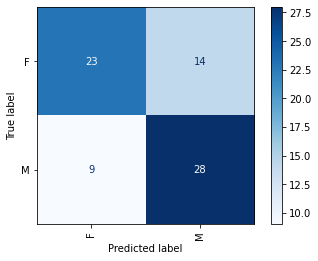

In [22]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues')

In [23]:
coefs = best_model.coef_  # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)


In [24]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names

['WORD_2_!!!_Felice',
 'WORD_2_!!_!',
 'WORD_2_!!_)',
 'WORD_2_!!_.',
 'WORD_2_!_!',
 'WORD_2_!_!!',
 'WORD_2_!_"',
 'WORD_2_!_)',
 'WORD_2_!_,',
 'WORD_2_!_-',
 'WORD_2_!_.',
 'WORD_2_!_:',
 'WORD_2_!_?',
 'WORD_2_!_Dio',
 'WORD_2_!_Provessore',
 'WORD_2_!_Quel',
 'WORD_2_!_atroce',
 'WORD_2_!_dato',
 'WORD_2_!_perchè',
 'WORD_2_!_voce',
 'WORD_2_!_»',
 'WORD_2_!_”',
 'WORD_2_!…_"',
 'WORD_2_!…_dovete',
 'WORD_2_!…_”',
 'WORD_2_"_!',
 'WORD_2_"_"',
 'WORD_2_"_(',
 'WORD_2_"_)',
 'WORD_2_"_,',
 'WORD_2_"_-',
 'WORD_2_"_.',
 'WORD_2_"_;',
 'WORD_2_"_A',
 'WORD_2_"_Abbiamo',
 'WORD_2_"_Adesso',
 'WORD_2_"_Allegro',
 'WORD_2_"_Allughite',
 'WORD_2_"_Auguri',
 'WORD_2_"_Bastianu',
 'WORD_2_"_Bè',
 'WORD_2_"_Che',
 'WORD_2_"_Ci',
 'WORD_2_"_Ciao',
 'WORD_2_"_Danzo',
 'WORD_2_"_Diario',
 'WORD_2_"_Dimentica',
 'WORD_2_"_E',
 'WORD_2_"_Eh',
 'WORD_2_"_Espresso',
 'WORD_2_"_Farina',
 'WORD_2_"_Fate',
 'WORD_2_"_Ginamona',
 'WORD_2_"_Già',
 'WORD_2_"_Giò',
 'WORD_2_"_Gobbetta',
 'WORD_2_"_Grazi

Feature importance


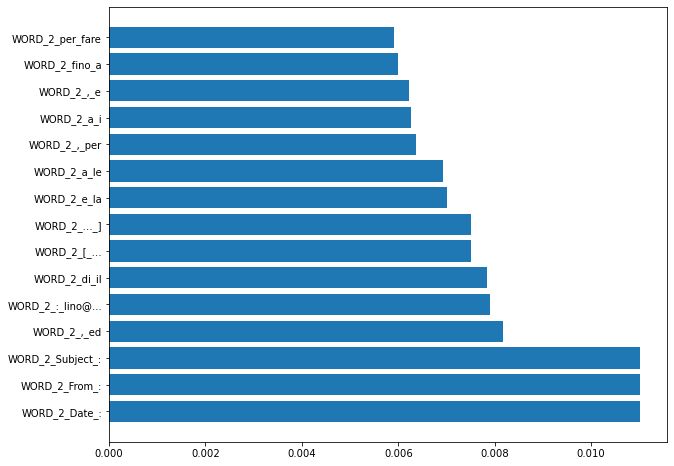

In [25]:
import matplotlib.pyplot as plt

# Assuming `coefs` is your coefficients obtained from the SVM model
# Assuming `features_names` is a list containing the names of your features
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

num_to_plot = 15
print(f'Feature importance')
plt.figure(figsize=(10, 8))
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()


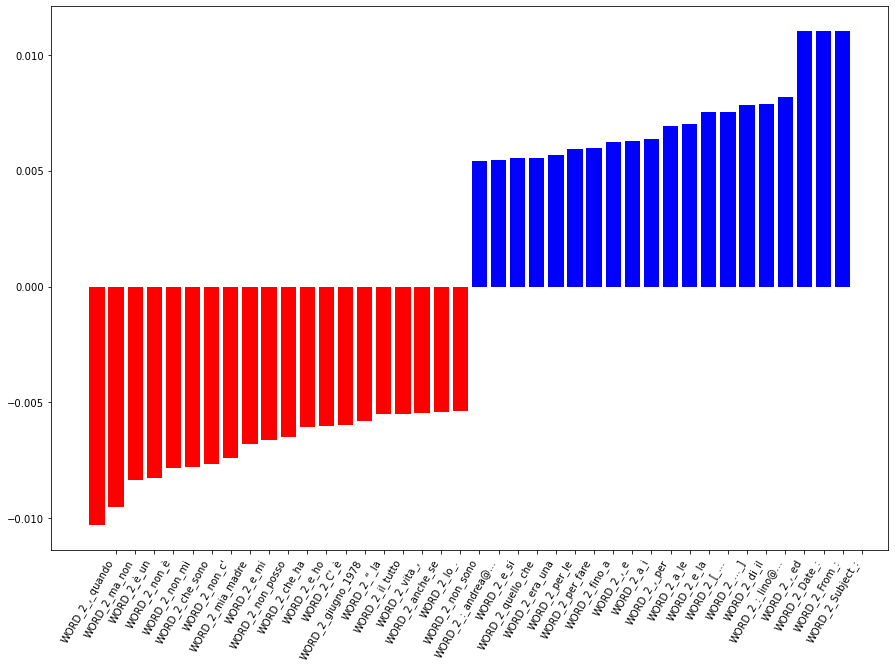

In [26]:
coef = coefs.ravel()
top_positive_coefficients = np.argsort(coef)[-20:]
top_negative_coefficients = np.argsort(coef)[:20]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 10))
colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 20), coef[top_coefficients], color=colors)
feature_names = np.array(features_names)
plt.xticks(np.arange(1, 1 + 2 * 20), feature_names[top_coefficients], rotation=60, ha="right")
plt.show()

# Trigrammi con POS, Lemma, Word

Report modello con trigrammi

Numero features: 83221

Best parameters found: {'C': 0.001, 'dual': True}
Best score found: 0.5750000000000001
              precision    recall  f1-score   support

           F       0.69      0.78      0.73        37
           M       0.75      0.65      0.70        37

    accuracy                           0.72        74
   macro avg       0.72      0.72      0.71        74
weighted avg       0.72      0.72      0.71        74


Feature importance


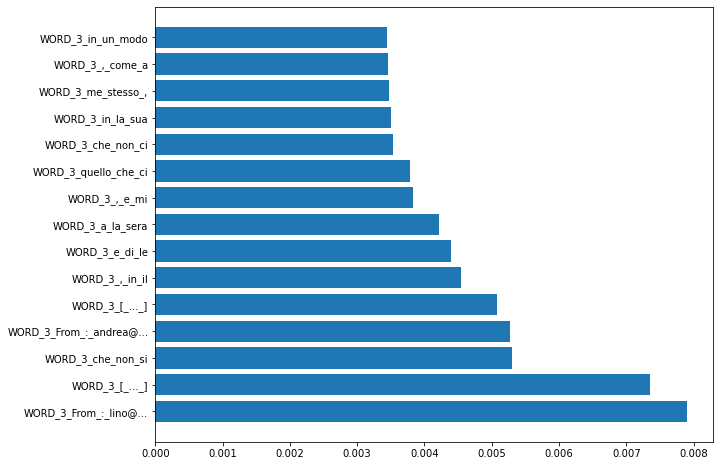

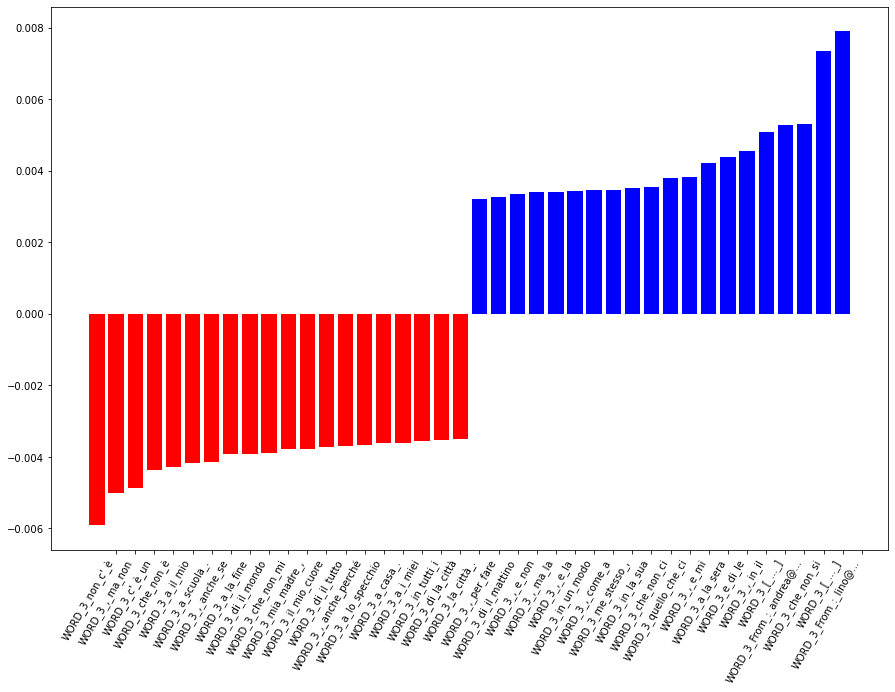

Confusion Matrix


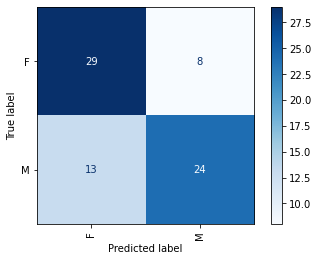

In [27]:
# Bigrammi con Word, POS, Lemma
extract_documents_ngrams(all_documents, n=3) # n=unigramma, bigramma, trigramma, quadrigramma
extract_documents_ngrams_normalized(all_documents, n=3)
def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.gender)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.gender)
    
    return train_features_dict, train_labels, test_features_dict, test_labels
train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels)

print("Report modello con trigrammi")
print()
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')
#train_features_dict = filter_features(train_features_dict, 5)
#print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')


vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
vectorizer.get_feature_names_out(X_train).tolist()

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

# Define the parameter grid to search through
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

print()
# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
X_test = vectorizer.transform(test_features_dict)
X_test = scaler.transform(X_test)
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True
print()


coefs = best_model.coef_  # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names

# Assuming `coefs` is your coefficients obtained from the SVM model
# Assuming `features_names` is a list containing the names of your features
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

num_to_plot = 15
print(f'Feature importance')
plt.figure(figsize=(10, 8))
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()

coef = coefs.ravel()
top_positive_coefficients = np.argsort(coef)[-20:]
top_negative_coefficients = np.argsort(coef)[:20]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 10))
colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 20), coef[top_coefficients], color=colors)
feature_names = np.array(features_names)
plt.xticks(np.arange(1, 1 + 2 * 20), feature_names[top_coefficients], rotation=60, ha="right")
plt.show()



print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues')

# Quadrigrammi con POS, Lemma, Word

Report modello con quadrigrammi

Numero features: 85056

Best parameters found: {'C': 0.001, 'dual': True}
Best score found: 0.53
              precision    recall  f1-score   support

           F       0.54      0.92      0.68        37
           M       0.73      0.22      0.33        37

    accuracy                           0.57        74
   macro avg       0.63      0.57      0.51        74
weighted avg       0.63      0.57      0.51        74


Feature importance


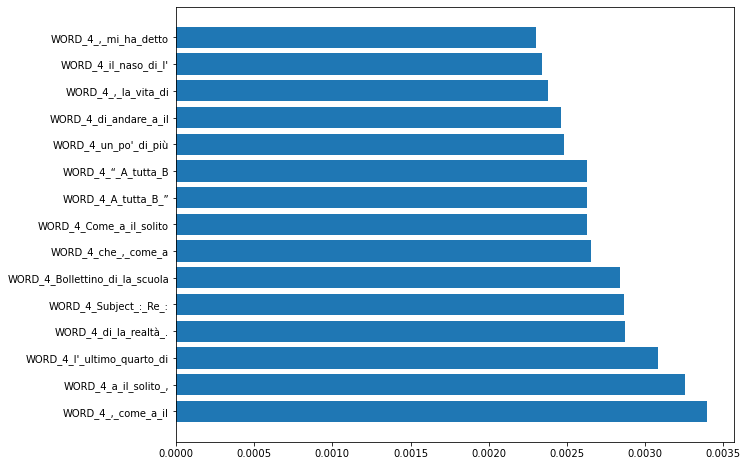

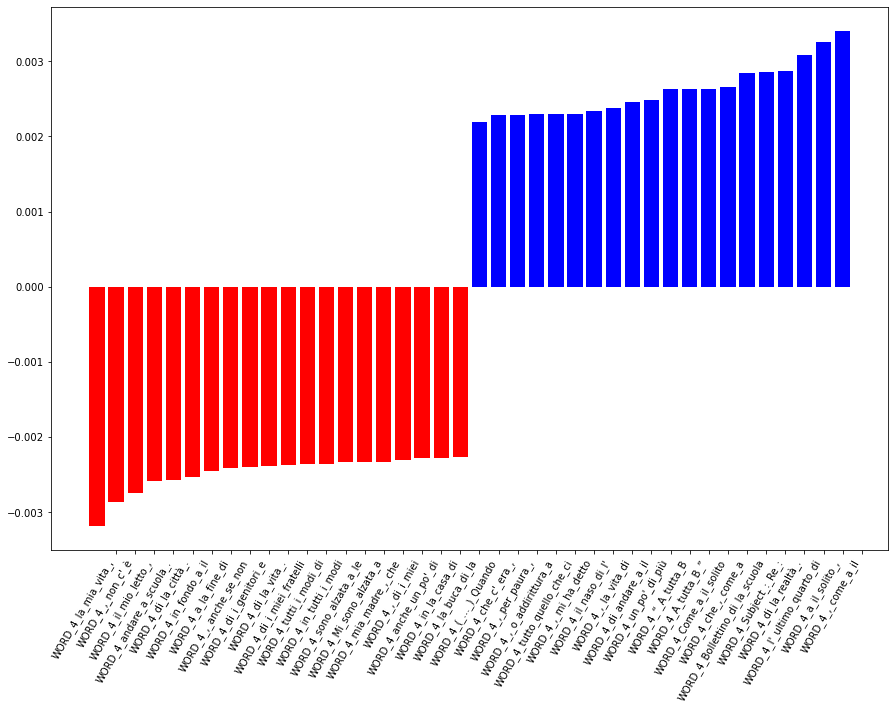

Confusion Matrix


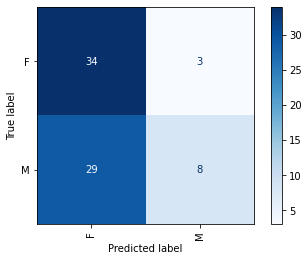

In [28]:
# Bigrammi con Word, POS, Lemma
extract_documents_ngrams(all_documents, n=4) # n=unigramma, bigramma, trigramma, quadrigramma
extract_documents_ngrams_normalized(all_documents, n=4)
def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.gender)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.gender)
    
    return train_features_dict, train_labels, test_features_dict, test_labels
train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels)

print("Report modello con quadrigrammi")
print()
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')
#train_features_dict = filter_features(train_features_dict, 5)
#print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')


vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
vectorizer.get_feature_names_out(X_train).tolist()

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

# Define the parameter grid to search through
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

print()
# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
X_test = vectorizer.transform(test_features_dict)
X_test = scaler.transform(X_test)
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True
print()


coefs = best_model.coef_  # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names

# Assuming `coefs` is your coefficients obtained from the SVM model
# Assuming `features_names` is a list containing the names of your features
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

num_to_plot = 15
print(f'Feature importance')
plt.figure(figsize=(10, 8))
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()

coef = coefs.ravel()
top_positive_coefficients = np.argsort(coef)[-20:]
top_negative_coefficients = np.argsort(coef)[:20]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 10))
colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 20), coef[top_coefficients], color=colors)
feature_names = np.array(features_names)
plt.xticks(np.arange(1, 1 + 2 * 20), feature_names[top_coefficients], rotation=60, ha="right")
plt.show()



print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues')